In [9]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Reshape
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Add 
from keras import backend as K
from keras import regularizers, optimizers
import re
from scipy.misc import imsave
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub%matplotlib inline

In [12]:
x = np.load('home/kushalgbk/Desktop/acad/ai-asg2/complete_images.npy')
y=np.load('home/kushalgbk/Desktop/acad/ai-asg2/gt.npy')

In [16]:
train_indices = np.random.choice(2000,1500,replace = False)
x_train_images = []
y_train_labels = [] 
for i in train_indices:
    x_train_images.append(x[i])
    y_train_labels.append(y[i])

test_indices = [xy for xy in range(2000) if xy not in train_indices]
print(test_indices)
x_test_images = []
y_test_labels = []

for i in test_indices:
    x_test_images.append(x[i])
    y_test_labels.append(y[i])

In [17]:
x_train = np.array(x_train_images)
x_test = np.array(x_test_images)
y_train = np.array(y_train_labels)
y_test = np.array(y_test_labels)


In [26]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [27]:
np.save("x_train2.npy",x_train)
np.save("x_test2.npy", x_test)
np.save("y_train2.npy",y_train)
np.save("y_test2,npy", y_test)

In [28]:
x_train = np.load('x_train2.npy')
x_test = np.load('x_test2.npy')
y_train = np.load('y_train2.npy')
y_test = np.load('y_test2,npy.npy')

In [29]:
rows = 256
cols = 128data_shape = 216*64
weight_decay = 0.0001

In [31]:
inputs = Input(shape=(None,None,3))

L1 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(inputs)
L2 = BatchNormalization()(L1)
L2 = Activation('relu')(L2)
L3 = MaxPooling2D(pool_size=(2,2))(L2)
L4 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L3)
L5 = BatchNormalization()(L4)
L5 = Activation('relu')(L5)
L6 = MaxPooling2D(pool_size=(2,2))(L5)
L7 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L6)
L8 = BatchNormalization()(L7)
L9 = Activation('relu')(L8)
L10 = Conv2D(128,(3,3),dilation_rate= (2,2), padding = "same", activation='relu', name = "conv_dil_1")(L9)
L11 = BatchNormalization()(L10)
L12 = Activation('relu')(L11)
L13 = Conv2D(128,(3,3),dilation_rate= (4,4), padding = "same", activation='relu', name = "conv_dil_2")(L12)
L14 = BatchNormalization()(L13)
L15 = Activation('relu')(L14)
L16 = Conv2D(128,(3,3),dilation_rate= (8,8), padding = "same", activation='relu', name = "conv_dil_3")(L15)
L17 = BatchNormalization()(L16)
L18 = Activation('relu')(L17)
L19 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay),
             name="skip_conv_1")(L6)
L20 = Add()([L18,L19])
L21 = UpSampling2D( size = (2,2)) (L20)
L21 = Conv2D(128,(3,3), padding = "same", kernel_regularizer=regularizers.l2(weight_decay))(L21)
L22 = BatchNormalization()(L21)
L23 = Activation('relu')(L22)
L24 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay),
             name="skip_conv_2")(L3)
L24 = Add()([L23,L24])
L25 = UpSampling2D(size = (2,2))(L24)
L25 = Conv2D(64, (3,3), padding = "same", kernel_regularizer=regularizers.l2(weight_decay))(L25)
L26 = BatchNormalization()(L25)
L27 = Activation('relu')(L26)
L28 = Conv2D(1,kernel_size=(1,1),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L27)#

L30 = Activation('sigmoid')(L28)
model = Model(inputs = inputs, outputs = L30)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 6 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [36]:
y_train = y_train.reshape(y_train.shape[0],256,256,1)
y_test = y_test.reshape(y_test.shape[0],256,256,1)smooth = 1

In [39]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def customized_loss(y_true,y_pred):
    return (1*K.binary_crossentropy(y_true, y_pred))+(0.5*dice_coef_loss(y_true, y_pred))

optimiser = optimizers.Adam(lr = 0.01)
model.compile(optimizer=optimiser,loss=dice_coef_loss,metrics=['accuracy',dice_coef])

In [44]:
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('segmentation_lr_e2_bs4.csv')
model_chekpoint = ModelCheckpoint("segmentation_lr_e2_bs4.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [45]:
model.fit(x_train,y_train,batch_size=4,epochs=20,validation_data=(x_test, y_test),callbacks=[lr_reducer, csv_logger,model_chekpoint])

Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 11241s 7s/step - loss: -0.3401 - acc: 0.6109 - dice_coef: 0.3786 - val_loss: -0.3894 - val_acc: 0.6854 - val_dice_coef: 0.3523

Epoch 00001: val_loss improved from inf to -0.35187, saving model to segmentation_lr_e2_bs4.hdf5


ImportError: `save_model` requires h5py.

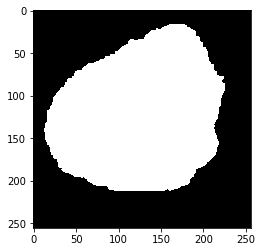

In [56]:
plt.imshow(gt, cmap = "gray")

In [58]:
gt = y_test[0].reshape((256,256))testing_image = x_test[0].reshape((1,256,256,3))
prediction = model.predict(testing_image)
prediction = prediction.reshape((256,256))
sample = prediction > 0.5


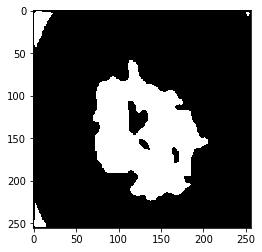

In [64]:
plt.imshow(sample, cmap = "gray")